# Vorlesung: Clustering

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE  
import re

import hdbscan

In [5]:
from ipywidgets import *
from io import BytesIO
from skimage import io
from medDiaJson import textId2imagegrid

In [6]:
%matplotlib notebook

# Cluster-Analyse mittelalterlicher Diagramme

In einer Sammlung mittelalterlicher Diagramme sollen mittels Cluster-Analyse Ähnlichkeiten festgestellt werden. Ziel ist es, aus diesen Ähnlichkeiten Kopier-Beziehungen abzuleiten und so, wenn möglich, die ursprüngliche Version einer Textfassung festzustellen, von der andere Versionen kopiert wurden.

Die Diagramme sind nach Merkmalen in Diagramm-Typen vor-kategorisiert. Es gibt 27 verschiedene Diagramm-Typen, mit jeweils etwa 30 Merkmalen. Jedes Diagramm kann die spezifischen Merkmale haben (=1) oder nicht haben (=0). 

Ein Text eines Authors kann verschiedene Diagramme enthalten. Die Zusammenfassung aller vorhandenen Merkmale ergibt eine Beschreibung des Texts als binären Vektor (0 oder 1). Merkmale anderer Diagramm-Typen werden auf Null gesetzt, nicht vorhandene oder unklare Merkmalsattribute werden ebenfalls mit dem Wert 0 beschrieben. 

Die Datenbank mittelalterlicher Diagramme wird von Github eingelesen und in einen Dataframe geschrieben.

In [7]:
url = 'https://raw.githubusercontent.com/grasshoff/ComputationalHistoryScience/master/diaattr.json'
diagrams = pd.read_json(url)
diagrams.head()

,altID,author,biblio,diaAttr,diaID,diaTyp,diaURL,foliopage,manID,manURL,textID,textURL,year
0,Plin4,Plinius,"Vaticano BAV, Ross. 247","[{'M2.9': 0, 'M2.18': 1, 'M2.13': 1, 'M2.16': ...",MAPD0668,2,Dl_1&pn=396&dw=1858&dh=901&ww=0.8926&wh=0.6552...,200v,DL(1),Dl_1&pn=1,DL(1)_A,,IX
1,Plin41,Plinius,"Vaticano BAV, Ross. 247","[{'M3.37': 0, 'M3.32': 0, 'M3.31': 1, 'M3.9': ...",MAPD0670,3,Dl_1&pn=395&dw=1858&dh=901&ww=0.9617&wh=0.7723...,200r,DL(1),Dl_1&pn=1,DL(1)_A,,IX
2,Plin67,Plinius,"Vaticano BAV, Ross. 247","[{'M4.4': 0, 'M4.8': 1, 'M4.1': 0, 'M4.6': 0, ...",MAPD0698,4,Dl_1&pn=414&dw=1858&dh=901&ww=0.9085&wh=0.6452...,209v,DL(1),Dl_1&pn=1,DL(1)_A,,IX
3,Plin82,Plinius,"Vaticano BAV, Ross. 247","[{'M6.2': 0, 'M6.17': 1, 'M6.16': 0, 'M6.15': ...",MAPD0714,6,Dl_1&pn=393&dw=1858&dh=901&ww=0.8255&wh=0.62&w...,199r,DL(1),Dl_1&pn=1,DL(1)_A,,IX
4,Plin6,Plinius,"Paris BN, 11130","[{'M2.9': 0, 'M2.18': 1, 'M2.13': 0, 'M2.16': ...",MAPD0690,2,Jk_2&pn=1&dw=1858&dh=901&ww=1&wh=1&wx=0&wy=0,74v,JK(2),Jk_2&pn=1,JK(2)_A,,XII


Um ein Clustering der Diagramme nach Merkmalen durchzuführen, erzeugen wir als erstes einen Dataframe, welcher neben dem Author die ID des Diagramms, seine Merkmale und die ID des zugehörigen Textes enthält. 
Wir konzentrieren uns auf den Author Martianus Capella.

In [8]:
textMerkmale=diagrams[["author","diaID","diaAttr","textID"]].reset_index(drop=True)
dfCapella = textMerkmale[textMerkmale['author']=='Capella']
dfCapella.head()

,author,diaID,diaAttr,textID
314,Capella,MAPD0345,"[{'M22.1': 0, 'M22.3': 0, 'M22.6': 0, 'M22.4':...",LK(1)_B
411,Capella,MAPD0347,"[{'M20.4': 0, 'M20.2': 0, 'M20.5': 0, 'M20.1':...",NW(2)_A
466,Capella,MAPD0386,"[{'M21.5': 1, 'M21.1': 0, 'M21.3': 1, 'M21.6':...",AY(3)_A
467,Capella,MAPD0397,"[{'M22.1': 1, 'M22.3': 1, 'M22.6': 0, 'M22.4':...",AY(3)_A
519,Capella,MAPD0292,"[{'M19.5': 0, 'M19.4': 0, 'M19.1': 1, 'M19.2':...",AY(1)_A


Um für jeden Text einen Beschreibungs-Vektor zu erhalten, fassen wir alle Attribute der zugehörigen Diagramme zu einem Dataframe zusammen. Die Text-ID wird als Information an den Vektor angehängt.

Zweierlei Bereinigungen finden hier statt: Zum einen werden Spalten mit dem Attribut M0 fallen gelassen. Dies ist keine korrekte Klassifizierung. Zum anderen werden Einträge mit einem ? durch eine Null ersetzt, um einen binären Vektor zu erhalten.

In [9]:
dfList = []
subList = []
for text in set(dfCapella['textID'].values):
    dfTemp = dfCapella[dfCapella['textID']==text].reset_index(drop=True)
    subList = []
    for i in range(len(dfTemp)):
        j = pd.DataFrame(dfTemp['diaAttr'].iloc[i])
        subList.append(j)
    dfTemp2 = pd.concat(subList,axis=1,join_axes=[subList[0].index]).fillna(0)
    dfTemp2['textID'] = text
    vlList = list(pd.unique(dfTemp2.values.ravel()))
    if '?' in vlList:
        dfTemp2.replace(['?'],[0.5],inplace=True)
    if 'M0' in dfTemp2:
        dfTemp2 = dfTemp2.drop('M0',1)
    dfList.append(dfTemp2)  

Es gibt 32 verschiedene Texte mit unterschiedlicher Anzahl an Diagramm-Attributen.

In [10]:
dfList[7]

,M28.1,M28.2,M28.3,M28.4,M28.5,M29.1,M29.2,M29.3,M29.4,M29.5,...,M31.19,M31.2,M31.3,M31.4,M31.5,M31.6,M31.7,M31.8,M31.9,textID
0,0,0,1,0,0.5,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,BC(1)_A


Das Zusammenfügen aller Texte muss schrittweise erfolgen, da die Dimensionen der unterschiedlichen Dataframes nicht unbedingt kompatibel sind. Da die Liste der Dataframes nicht sortiert ist, muss dieser Schritt möglicherweise per Hand angepasst werden.

In [11]:
dfL1 = [x for x in dfList if x.shape[1] < 15]
dfL2 = [x for x in dfList if x.shape[1] > 15]
dfL3 = [x for x in dfList if x.shape[1] == 15]

In [12]:
p1 = pd.concat(dfL1)

In [13]:
p2 = pd.concat(dfL2)

Problematisch ist ein Dataframe mit 15 Spalten.

In [14]:
dfL3[0]

,M21.1,M21.2,M21.3,M21.4,M21.5,M21.6,M21.7,M21.1,M21.2,M21.3,M21.4,M21.5,M21.6,M21.7,textID
0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,JP(1)_A


Hier scheint es ein Problem in der Datenbank zu geben. Ein Text enthält zwei Diagramme gleichen Typs, die aber jeweils keine klaren Merkmale aufweisen (kodiert mit ?).

In [15]:
diagrams[diagrams['textID']=='JP(1)_A']

,altID,author,biblio,diaAttr,diaID,diaTyp,diaURL,foliopage,manID,manURL,textID,textURL,year
654,Cape27,Capella,"Karlsruhe LB, Aug. CLXVII","[{'M21.5': '?', 'M21.1': '?', 'M21.3': '?', 'M...",MAPD0389,21,,16r,JP(1),,JP(1)_A,,IX(850)
655,Cape28,Capella,"Karlsruhe LB, Aug. CLXVII","[{'M21.5': '?', 'M21.1': '?', 'M21.3': '?', 'M...",MAPD0390,21,,16r,JP(1),,JP(1)_A,,IX(850)


Der daraus resultierenden Dataframe kann nicht angefügt werden, weil sich Spalten-Namen wiederholen. Da die Beschreibung des Textes als Vektor einfach einem 0.5-Vektor entspricht, konstruieren wir diesen Eintrag per Hand.

In [16]:
dfJP1_A = pd.DataFrame([{'M21.1':0.5,'M21.2':0.5,'M21.3':0.5,'M21.4':0.5,'M21.5':0.5,'M21.6':0.5,'M21.7':0.5, 'textID':'JP(1)_A'}])
dfJP1_A

,M21.1,M21.2,M21.3,M21.4,M21.5,M21.6,M21.7,textID
0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,JP(1)_A


Nun können alle Teil-Dataframes zusammengefügt werden. Diagramm-Attribute, die in einem Text nicht vorkommen, werden auf Null gesetzt. Da die Text-ID im Dataframe enthalten ist, können wir einen neuen Lauf-Index erzeugen ohne Informationen zu verlieren. 

In [17]:
dfTexte = pd.concat([p1,p2,dfJP1_A]).fillna(0).reset_index(drop=True)

In [18]:
zeroVecs = [i for i in range(len(dfTexte)) if list(dfTexte.sum(axis=1))[i] == 0]

In [19]:
zeroVecs

[3, 5]

Die Daten müssten weiter bereinigt werden, wenn es noch andere Werte außer Zahlen gibt. Hiervon sind die Text-IDs ausgenommen (beginnend mit einem Großbuchstaben).

In [20]:
vlList = list(pd.unique(dfTexte.values.ravel()))
[x for x in vlList if not re.findall(r'[A-Z].',str(x))]

[0.0, 1.0, 0.5]

Eine Matrix erhält man durch den df.values Befehl.

In [21]:
X = dfTexte.drop('textID',1).drop(0,0).drop(17,0).values.astype(int)

Über die Text-ID können die Bilder aller Diagramme aus dem edition-topoi repository geladen werden.

In [22]:
textIDs = list(dfTexte['textID'].drop(0,0).drop(17,0).values)

In [23]:
textIDs[0]

'BA(3)_A'

In [24]:
def imgShow(index):
    return textId2imagegrid(diagrams,index)

In [25]:
j = widgets.interactive(imgShow, index=textIDs)
HBox([j])

Die Spalte mit den Text-IDs wird nun erstmal fallen gelassen. Später kann über den Index die zugehörige Text-ID ausgelesen werden.

In [26]:
data = X
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Projektion des Merkmal-Raums auf 2D

Für eine 2D Darstellung muss eine Projektion verwendet werden, da die Daten selbst die Dimensionen 32 (Texte) x 102 (Merkmale) haben. 
Hierfür bietet sich TSNE aus dem Paket sklearn an. Die Beschreibung der Funktionsweise findet sich unter http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

Diese Projektion ist stochastisch, das heißt bei einem neuen Aufruf kann sich eine andere Verteilung ergeben. Die Projektion dient nur zur Darstellung, zB für verschiedene Cluster-Größen oder Abstandsmaße. 

In [27]:
projection = TSNE().fit_transform(data)

<IPython.core.display.Javascript object>


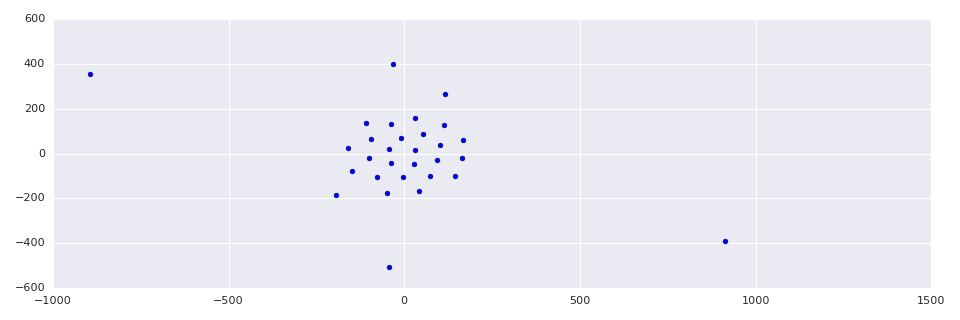

In [28]:
fig = plt.figure(figsize=(12,4))
plt.scatter(*projection.T)

## Cluster-Analyse

### Cluster Analyse mit scipy linkage

Wie bei der Cluster- Analyse der Diagramme, können wir auch bei den Texten das paket scipy.linkage nutzen.

In [42]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [43]:
Z = linkage(X, method='average', metric='hamming')
len(Z)

29

<IPython.core.display.Javascript object>


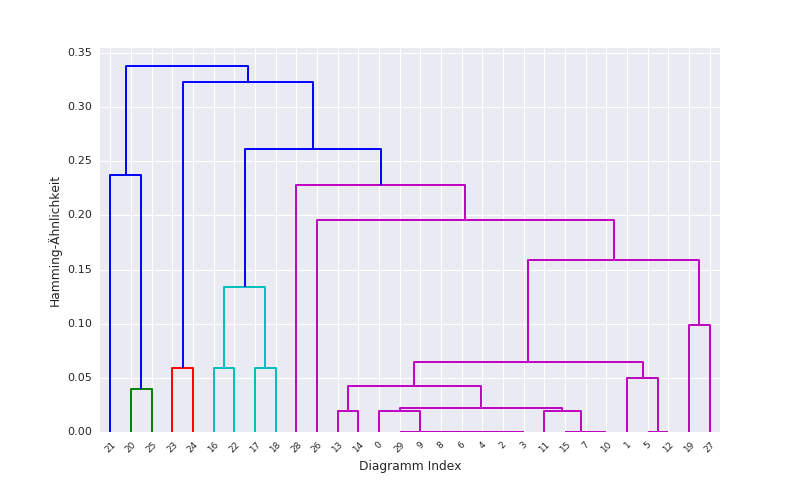

In [44]:
ig,ax = plt.subplots(1,1,figsize=(10, 6),sharey=True,sharex=True)

fig.set_label('Hierarchische Cluster-Analyse')
fig.set_tight_layout(True)
plt.xlabel('Diagramm Index')
plt.ylabel('Hamming-Ähnlichkeit')
dendrogram(
    Z,
    leaf_font_size=8.,  # font size for the x axis labels
    ax=ax
);

In [45]:
from scipy.cluster.hierarchy import fcluster
max_d = 0.25
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 1, 1, 3,
       2, 2, 1, 4, 4, 4, 4], dtype=int32)

In [46]:
from sklearn import decomposition
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)

<IPython.core.display.Javascript object>


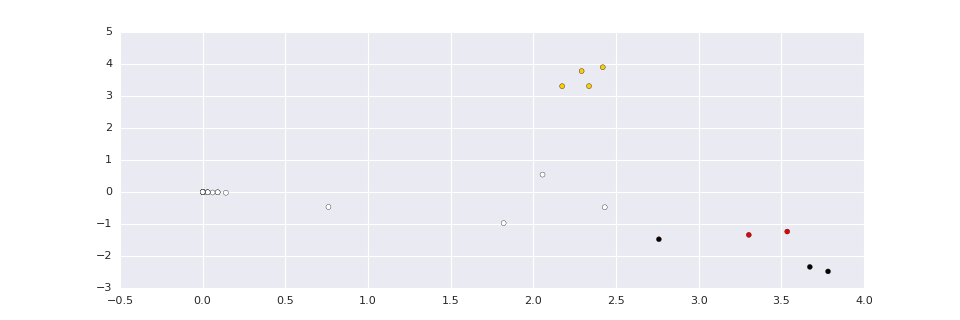

In [47]:
fig = plt.figure(figsize=(12,4))
plt.scatter(*X_pca.T, c=clusters, cmap='hot');

### hdbscan Algorithmus

Als Clustering-Algorithmus verwenden wir HDBSCAN, eine Weiterentwicklung im Umfeld des Scikit-Learn Pakets https://github.com/scikit-learn-contrib/hdbscan 

### Grundlage des Algorithmus

Die grundlegende Idee des HDBSCAN Clusteres ist, ein gewichtetes Abstandsmaß für die Daten einzuführen, welches erlaubt Daten von Rauschen zu trennen. Anschaulich wird um jeden Datenpunkt ein Kreis gezogen, der `min_sample`=N Datenpunkte enthält. Der Radius zweier Punkte wird mit ihrem Abstand, berechnet je nach gewünschter Metrik, verglichen und der größte Wert wird als Entfernung der zwei Datenpunkte definiert. 

<img src="./distance4a.svg" width="500"> Quelle: [How hdbscan works](http://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html)

In obigen Bild ist zB. der Abstand über die Metrik zwischen dem blauen und grünen Kreis kleiner als der Radius des grünen Kreises. Da der Abstand über den größten Wert definiert ist, wird zwischen den beiden Punkten der Abstand als der Radius des grünen Kreises gesetzt. Bei dem Abstand zwischen roten und grünen Kreis verhält es sich anders. Hier ist der Abstand über die Metrik der größte Wert. 

Man spricht hier auch von einer "mutual reachability distance" (gegenseitige Erreichbarkeit). Diese Wahl der Entfernungsberechnung ist dafür verantworlich, dass der Algorithmus Datenpunkte gut von Rauschen trennen kann.

Ausgehend von diesen Abstandsdaten wird nun ein zufälliger Datenpunkt ausgewählt und eine Verbindung zu dem nächsten Datenpunkt mit dem geringsten Abstand gezogen. Dies wird so lange fortgesetzt, bis alle Datenpunkte verknüpft sind. Dieses neue Netzwerk bezeichnet man als Minimal Spanning Tree. Minimal daher, dass immer Verbindungen der geringsten Entfernung gewählt werden. "Spanning" (aufspannend) bedeuted, dass der Baum alle Punkte erreicht, aber keine geschlossenen Kurven enthält. 

<img src="./how_hdbscan_works_10_1.png" width="500"> Quelle: [How hdbscan works](http://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html)


Schließlich kann für die Erzeugung eines Ähnlichkeits-Diagramms (Dendrogramm) wieder die Entfernung genutzt werden. Im sogenannten Bottom-up oder agglomerativen Verfahren der Cluster-Bildung ist erst jeder Text ein eigener Cluster. Ausgehend von der geringsten Entfernung werden zwei Texte, oder ein Text und ein Cluster, zu einem neuen Cluster zusammengefügt, bis am Ende nur noch ein Cluster existiert. Diese neuen Cluster erhalten neue Indices, sodass zB für die Diagramme neue Cluster bei 722 starten, für die Texte hingegen bei 33. Zuerst führen wir die Clusterung durch, dann diskutieren wir die Details der Dendrogramm-Enstehung.

### Clustering
Erst wird der Clusterer initialisiert. Ein Aufruf mit `cluster.fit(data)` führt dann das Clustering durch. In der Ausgabe sieht man, welche Parameter als Standard benutzt werden.

In [26]:
clusterer = hdbscan.HDBSCAN(metric='hamming',p=1,min_cluster_size=3)
clusterer.fit(data)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, core_dist_n_jobs=4, gen_min_span_tree=False,
    leaf_size=40, match_reference_implementation=False,
    memory=Memory(cachedir=None), metric='hamming', min_cluster_size=3,
    min_samples=None, p=1)

Jeder Text wird einem Cluster zugeordnet, in Abhängigkeit seiner "Entfernung" zu anderen Texten. Die Auswahl der Metrik bestimmt, welches Entfernungsmaß für die Eigenschafts-Vektoren verwendet werden soll. Es gibt drei grundlegend unterschiedliche Gruppen von Maßen, je nachdem welche Werte die Beschreibungs-Vektoren annehmen können:

    reelle Zahlen: zB euclidean, minkowski, chebyshev
    ganze Zahlen: Hamming, Canberra, Braycurtis
    boolsche Werte (True/False): jaccard, dice (Für reelle Zahlen werden Werte ungleich null als True gesetzt.)
    
Für die binären Beschreibungs-Vektoren kommen also zB. jaccard, matching oder kulinski als Metriken in Frage. 

Die Zuordnung eines Diagrammes zu einem Cluster erhält man über den Befehl `clusterer.labels_`. Diagramme, die einem zu kleinen Cluster zugeordnet werden (kleiner als 2) erhalten das Label -1.

In [27]:
clusterer.labels_[:20]

array([ 1,  1,  1,  1,  1, -1, -1,  1, -1, -1,  1,  2,  2,  2,  1, -1,  0,
       -1,  0, -1])

Die Anzahl verschiedener Cluster.

In [28]:
clusterer.labels_.max()

2

Die Nähe zu einem Cluster-Kern wird mit `clusterer.probabilities_` beschrieben.

In [29]:
clusterer.probabilities_[:40]

array([ 1.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        0.        ,  0.86666667,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  1.        ,  0.        ,  0.        ,  1.        ])

## Dendrogramm Darstellung

Die Hierachie der Cluster kann mit einem Dendrogramm dargestellt werden. Die Breite der Linie und ihre Farbe kodieren die Anzahl der Diagramme pro Cluster. 

<IPython.core.display.Javascript object>


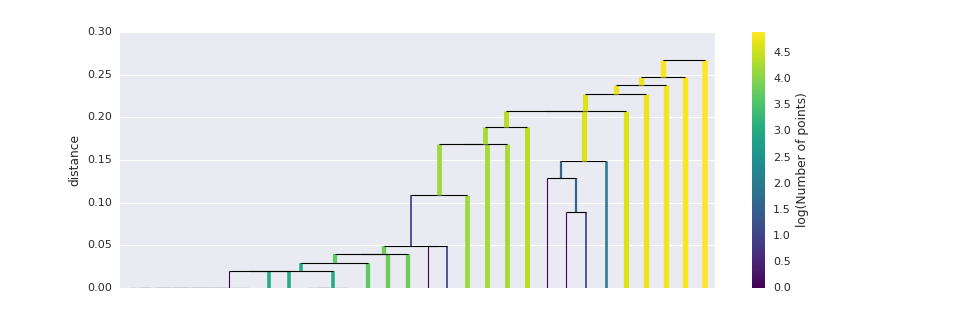

In [30]:
fig = plt.figure(figsize=(12,4))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

Über die Funktion to_pandas() wird das Dendrogramm als Dataframe ausgegeben.

In [31]:
dfSingleLink = clusterer.single_linkage_tree_.to_pandas()
dfSingleLink.head()

,parent,left_child,right_child,distance,size
0,30,0.0,2.0,0.0,2.0
1,31,30.0,4.0,0.0,3.0
2,32,31.0,7.0,0.0,4.0
3,33,32.0,10.0,0.0,5.0
4,34,33.0,14.0,0.0,6.0


Hier kann man den Vorgang der Dendrogramm Bildung sehr gut erkennen. 

    Schritt 0: Die Texte mit dem Index 1 und 9 haben einen Abstand von null, sie enthalten also exakt die selben Diagramme mit den selben Merkmalen. Daraus wird der Cluster mit der Nummer 32 gebildet.
    Schritt 1: Anschließend wird Cluster 32 mit dem Text 15 zusammen geführt zu Cluster 33, da auch hier der Abstand null ist. 
    Schritt 2: Die Texte 21 und 24 haben den nächst geringeren Abstand, sie werden zu Cluster 34. usw

Eine reduzierte Ansicht erhält man mit dem Condensed Tree. Hier werden nach und nach Verbindungen aus dem Haupt-Cluster entfernt. Knoten-Punkte die unter die minimale Cluster-Größe fallen, werden nicht mehr dargestellt.  

<IPython.core.display.Javascript object>


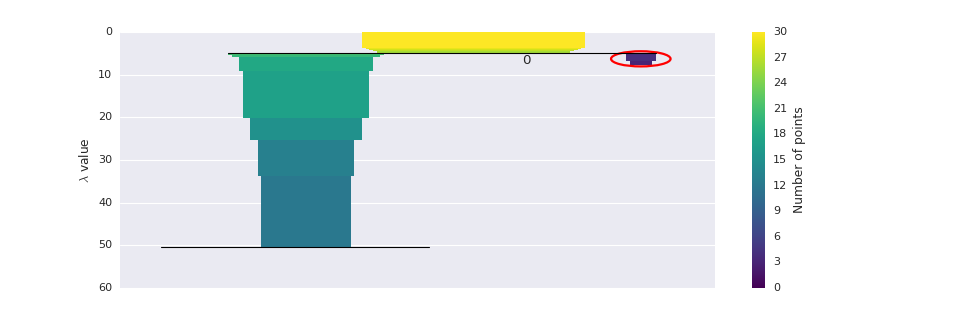

In [32]:
fig = plt.figure(figsize=(12,4))
clusterer.condensed_tree_.plot(select_clusters=True,label_clusters=True)

Die Information in diesem Dendrogramm kann direkt als Dataframe ausgegeben werden. 

In [33]:
dfClusterCond = clusterer.condensed_tree_.to_pandas()
dfClusterCond.head()

,parent,child,lambda_val,child_size
0,30,20,3.740741,1
1,30,22,4.040000,1
2,30,17,4.208333,1
3,30,24,4.391304,1
4,30,28,4.809524,1


### Minimum Spanning Tree


In [34]:
clustMin = hdbscan.HDBSCAN(algorithm='boruvka_balltree',metric='minkowski',p=3,min_cluster_size=3, approx_min_span_tree=False, min_samples=None,gen_min_span_tree=True)
clustMin.fit(data)

HDBSCAN(algorithm='boruvka_balltree', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=False, core_dist_n_jobs=4, gen_min_span_tree=True,
    leaf_size=40, match_reference_implementation=False,
    memory=Memory(cachedir=None), metric='minkowski', min_cluster_size=3,
    min_samples=None, p=3)

In [35]:
labelsDict = dfTexte['textID'].drop(0,0).drop(17,0).reset_index(drop=True).to_dict()

<IPython.core.display.Javascript object>


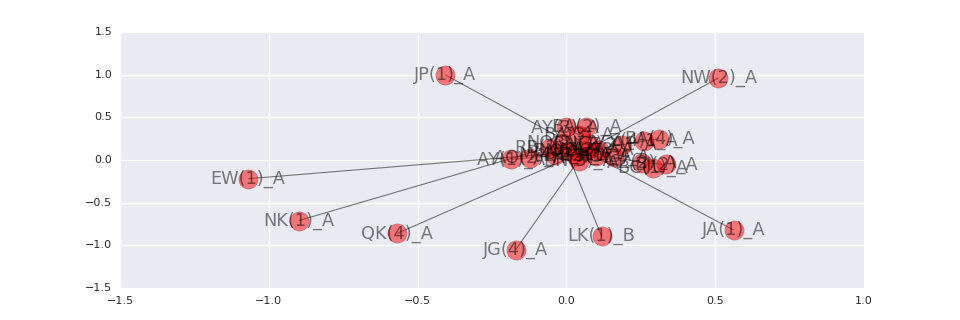

In [36]:
fig = plt.figure(figsize=(12,4))
graphN = clustMin.minimum_spanning_tree_.to_networkx()
nx.draw_networkx(graphN,labels=labelsDict,font_size=16,alpha=0.5)

In [37]:
diagrams[diagrams['textID']=='BA(3)_A']

,altID,author,biblio,diaAttr,diaID,diaTyp,diaURL,foliopage,manID,manURL,textID,textURL,year
599,Cape36,Capella,"Leiden UB, BPL, 87","[{'M22.2': 0, 'M22.6': 0, 'M22.5': 0, 'M22.1':...",MAPD0399,22,Ba_3&pn=126&dw=1858&dh=901&ww=0.1108&wh=0.2035...,124v,BA(3),Ba_3&pn=1,BA(3)_A,,IX


## Einfluss der Metrik auf Cluster Erzeugung

Die Liste aller möglichen Metriken erhält man mit `hdbscan.dist_metrics.METRIC_MAPPING`. Die Beschreibung der Mathematik dahinter findet sich im Quelltext https://github.com/scikit-learn-contrib/hdbscan/blob/master/hdbscan/dist_metrics.pyx

In [38]:
clusterer = hdbscan.HDBSCAN(metric='jaccard',min_cluster_size=2)
clusterer1 = hdbscan.HDBSCAN(metric='kulsinski',min_cluster_size=2)
clusterer2 = hdbscan.HDBSCAN(metric='matching',min_cluster_size=2)

In [39]:
clusterer.fit(data)
clusterer1.fit(data)
clusterer2.fit(data)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, core_dist_n_jobs=4, gen_min_span_tree=False,
    leaf_size=40, match_reference_implementation=False,
    memory=Memory(cachedir=None), metric='matching', min_cluster_size=2,
    min_samples=None, p=None)

In [40]:
color_palette = sns.color_palette('Paired', 50)

cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]

cluster_colors1 = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer1.labels_]
cluster_member_colors1 = [sns.desaturate(x, p) for x, p in zip(cluster_colors1, clusterer1.probabilities_)]

cluster_colors2 = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer2.labels_]
cluster_member_colors2 = [sns.desaturate(x, p) for x, p in zip(cluster_colors2, clusterer2.probabilities_)]

<IPython.core.display.Javascript object>


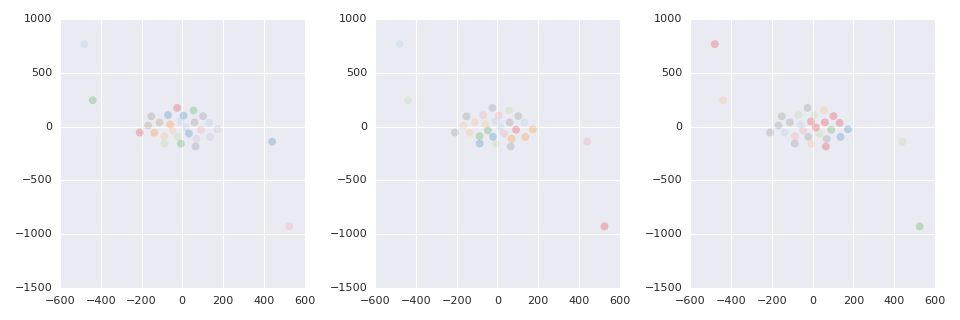

In [41]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
ax2.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors1, alpha=0.25)
ax3.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors2, alpha=0.25)

plt.tight_layout()

<IPython.core.display.Javascript object>


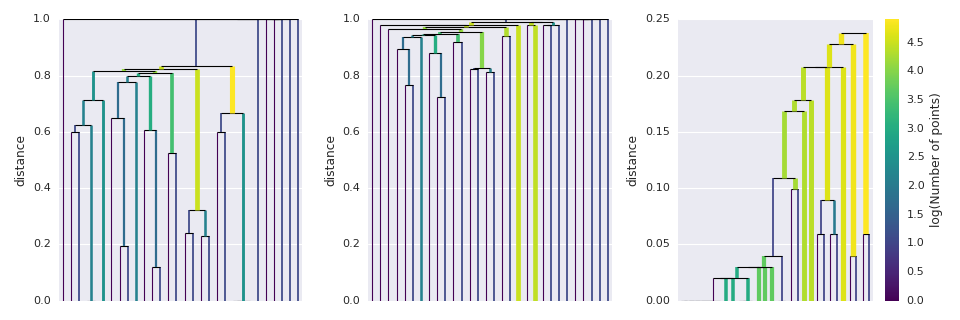

In [42]:
#fig = plt.figure(,sharey=True)
fig, ax = plt.subplots(1, 3, figsize=(12,4), sharex=False, sharey=False)

clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=False, axis=ax[0])
clusterer1.single_linkage_tree_.plot(cmap='viridis', colorbar=False, axis=ax[1])
clusterer2.single_linkage_tree_.plot(cmap='viridis', colorbar=True, axis=ax[2])

plt.tight_layout()

### Selbst definierte Metriken

Über die Auswahl von pyfunc soll auch das definieren eigener Metriken möglich sein. Diese könnte spezielles Wissen über die Daten beinhalten. So sollte es zB schwerer sein, ein Merkmal bei dem Kopieren von Diagrammen hinzuzufügen als wegzulassen. Daher sollte die "Entfernung" von 0 zu 1 größer sein als 1 zu 0. Damit wäre die so definierte Entfernung keine eigentliche Metrik mehr, da für diese immer Symmetrie ( d(x,y) = d(y,x) ) gelten muss.

In [43]:
def weightedattributes(u,v):
    dist = np.sqrt((1/(u+1)*(u-v)**2).sum())
    return dist

In [44]:
clusterer = hdbscan.HDBSCAN(algorithm='boruvka_balltree',metric='euclidean',min_cluster_size=3, gen_min_span_tree=True)
clusterer.fit(data)

HDBSCAN(algorithm='boruvka_balltree', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, core_dist_n_jobs=4, gen_min_span_tree=True,
    leaf_size=40, match_reference_implementation=False,
    memory=Memory(cachedir=None), metric='euclidean', min_cluster_size=3,
    min_samples=None, p=None)

<IPython.core.display.Javascript object>


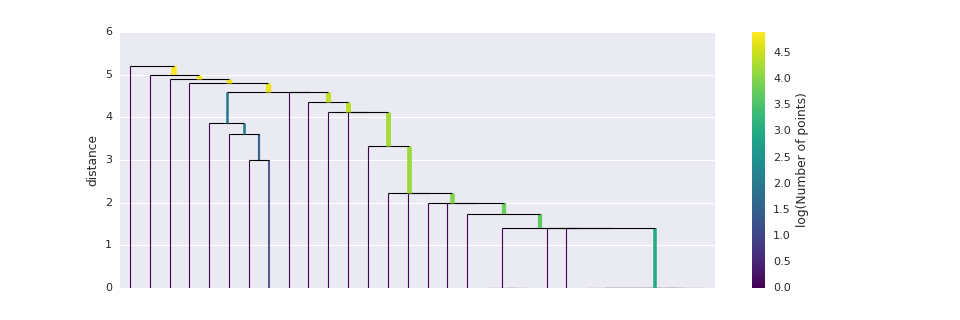

In [45]:
fig = plt.figure(figsize=(12,4))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

In [46]:
netw = clusterer.single_linkage_tree_.to_networkx()

<IPython.core.display.Javascript object>


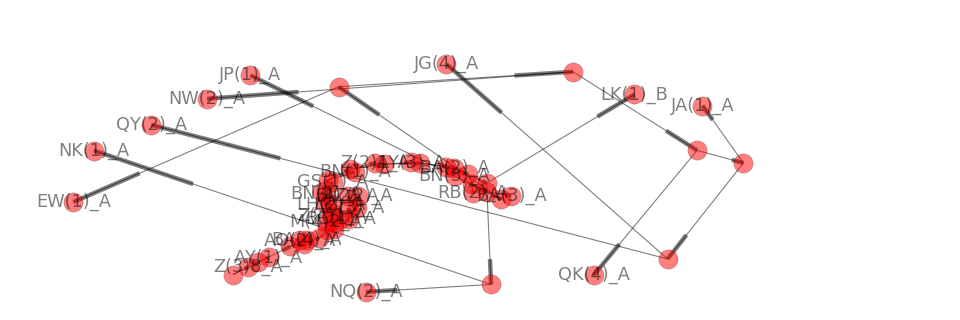

In [47]:
fig = plt.figure(figsize=(12,4))
nx.draw(netw,labels=labelsDict,font_size=16,alpha=0.5)

In [48]:
diagrams[diagrams['textID']=='LK(1)_B']

,altID,author,biblio,diaAttr,diaID,diaTyp,diaURL,foliopage,manID,manURL,textID,textURL,year
314,Cape149,Capella,"Leiden UB, Ms BPL 64","[{'M22.2': 1, 'M22.6': 0, 'M22.5': 1, 'M22.1':...",MAPD0345,22,Lk_1&pn=92&dw=1858&dh=901&ww=0.7615&wh=0.3906&...,46v,LK(1),Lk_1&pn=1,LK(1)_B,,XI
